<h1>Example: Gibbs Sampling</h1>
<hr>
DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

© 2023 Massachusetts Institute of Technology.

The software/firmware is provided to you on an As-Is basis

Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.

In [1]:
import numpy as np
import numpy.linalg as la
import scipy.linalg as sla
import pyLIQTR.sim_methods.quantum_ops as qops 
from   pyLIQTR.sim_methods.simqsp import SimQSP
import matplotlib.pyplot as plt
from itertools import combinations
import mpmath as mpm
from pyLIQTR.sim_methods.fitter import Fitter
from pyLIQTR.sim_methods.angler import Angler
import shadows as sh

In [ ]:
# Run an operator-level simulation of the algorithm in one function for scaling analysis
def op_sim(N, epsilon, delta):
    # Define Hamiltonian as in Heisenberg tutorials, using the XXZ model

    # Hamiltonian parameters

    J_z  =    1.0;

    J_x  =    1.1*J_z;     J_y  =   J_x;               
    h_x  =   -1.0*J_z;     h_y  =   0.0*J_z;     h_z  =   0.0*J_z;

    # Generate input parameter sets
    tuples,types,coeffs = qops.params_heisenberg_1d(N,
                                                    J_x=J_x,J_y=J_y,J_z=J_z,
                                                    h_x=h_x,h_y=h_y,h_z=h_z,
                                                    periodic=False)

    # Generate Hamiltonian Matrix
    H = qops.ham_from_pauli_tuples(tuples,types,coeffs,N)

    # Let us define our inverse temperature as beta = 0.5
    beta = 1.5
    # Calculate Gibbs State
    rho_beta = sla.expm(-beta*H)
    Z = np.trace(rho_beta)
    rho_beta = rho_beta/Z
    # Define our set of operators as all one and two qubit Pauli operators (they need only be Hermitian)
    op_tuples = list(combinations(range(N), 2))

    paulis = [qops.px,qops.py,qops.pz]
    O_list = []
    O = []

    # One qubit pauli operators over N qubits
    for i in range(N):
        ops = [qops.id]*N

        op_ids = [3]*N

        for j in range(3):
            ops[i] = paulis[j]
            O.append(qops.multikron(ops))

            op_ids[i] = j
            O_list.append(op_ids.copy())

    # Two qubit pauli operators over N qubits
    for tuple in op_tuples:
        ops = [qops.id]*N
        op_ids = [3]*N
        for i in range(3):
            for j in range(3):
                ops[tuple[0]] = paulis[i]
                ops[tuple[1]] = paulis[j]
                O.append(qops.multikron(ops))

                op_ids[tuple[0]] = i
                op_ids[tuple[1]] = j
                O_list.append(op_ids.copy())
    # Expectation values of operators for Gibbs State
    Gbs_expct = sh.expect_set(O, rho_beta)

    vars = []
    for o_j in O:
        vars.append(3**2 - abs(np.trace(rho_beta@o_j)**2))

    K = int(np.rint((9/2)*np.log(len(O)/delta)))
    S = np.rint((2/(epsilon**2))*max(vars)).astype(int) + 1 # Fulfill strictly greater than requirement

    n_s = K*S
    print('number of shadows required')
    print(n_s)

    # Pre processing for QSP requires Min-Max Rescaling

    evals,evecs = la.eig(H)

    e_min = np.min(evals)
    e_max = np.max(evals)

    ID_n = np.eye(2**N)

    H_rs = (H - e_min*ID_n) / (e_max - e_min)        # min/max rescaling  

    tau = beta*(e_max-e_min).real/2.0
    
    # Fit our exponential function to a 24-degree polynomial
    
    deg   = 24  

    exp_ite  =  lambda x : mpm.exp(-tau*np.abs(x))

    Fit  = Fitter(exp_ite, deg, parity=0, kappa = 8.0)

    Fit.remez()

    Fit.root_solver = 'ridder'  # switch to a slightly faster root solver
                                # though convergence can be erratic.
    Fit.r_eps_tot   = 1.0e-6

        
    # Angle generation
    Ang = Angler(cheb_poly=Fit, bfgs_conv=1e-8, max_iter=400 );   
    Ang.gradient_optimization();

    # Create simulation object and encode the Hamiltonian
    Sim_q = SimQSP(angler=Ang)

    Sim_q.get_qsp_operators(H_rs)

    # Prepare signal state and calculate unitary operator
    sig_qsp  = np.kron(np.array([[1,1]]),np.eye(2**N)) / np.sqrt(2)
    U_qsp = sig_qsp @ Sim_q.qsp_sequence() @ sig_qsp.T

    # Build initial state for TPQ Prep
    psi0 = qops.multikron([qops.sz_u]*N)             # Generate the wavefunction as a 
    psi0 = psi0 / la.norm(psi0)                      # Kronecker product and normalize it.

    # Calculate estimated expectation value using shadows + QSP
    estimates = []
    for i in range(n_s):
        U = sh.random_unitary(N, 1)
        phi = np.matmul(U, psi0)

        psiB_ap = np.matmul(U_qsp, phi) # Imaginary time evolution via QSP 
        psiB_ap = psiB_ap / la.norm(psiB_ap)

        estimates.append(sh.shadow_estimation(np.outer(psiB_ap, psiB_ap.conj()), N, O_list))

    shadow_expct = sh.med_of_mean(np.array(estimates), K)

    return np.mean(abs(np.subtract(Gbs_expct, shadow_expct))), n_s, len(O)


In [ ]:
errors = []
shadow_count = []
observable_count = []
N = [3, 4, 5, 6, 9, 10]
for n in N:
    error, shadows, M = op_sim(n, 0.2, 0.01)
    errors.append(error)
    shadow_count.append(shadows)
    observable_count.append(M)

In [ ]:
# Write results to file
f = open("results.txt", "w")
f.write('N\tError\tShadows\tObservables\n')
for i in range(len(N)):
    f.write(str(N[i])+'\t'+str(errors[i])+'\t'+str(shadow_count[i])+'\t'+str(observable_count[i])+'\n')
f.close()

In [16]:
# Read results from file
N = []
errors = []
shadow_count = []
observable_count = []

with open("results.txt", "r") as r:
    lines = r.readlines()[1:]
    for line in lines:
        data = line.split()
        N.append(int(data[0]))
        errors.append(float(data[1]))
        shadow_count.append(int(data[2]))
        observable_count.append(int(data[3]))


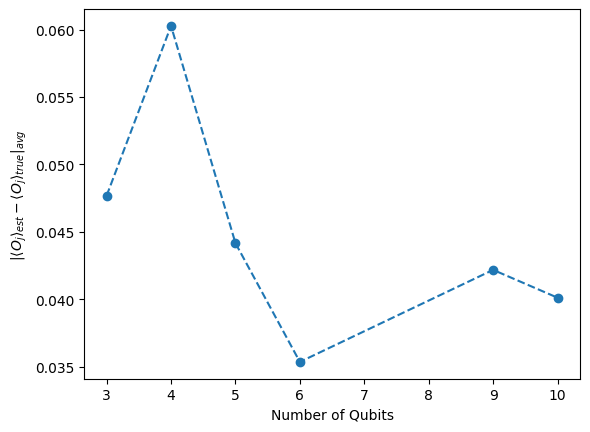

In [21]:
plt.xlabel('Number of Qubits')
plt.ylabel(r'|$\langle O_j \rangle _{est} - \langle O_j \rangle _{true}|_{avg}$')
plt.plot(N,errors, '--o')
plt.show()

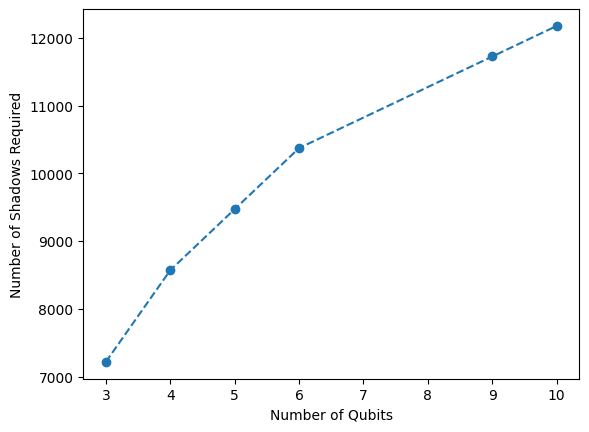

In [18]:
plt.xlabel('Number of Qubits')
plt.ylabel('Number of Shadows Required')
plt.plot(N,shadow_count, '--o')
plt.show()

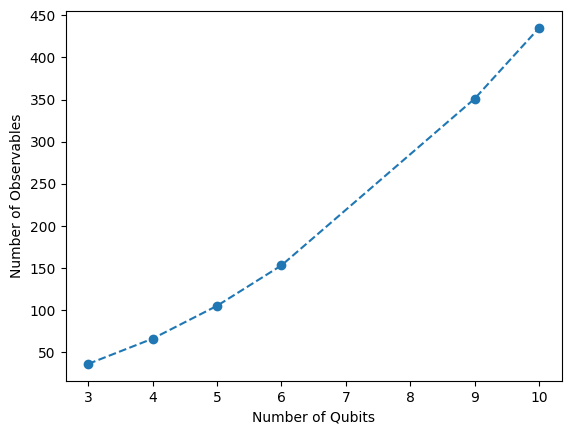

In [19]:
plt.xlabel('Number of Qubits')
plt.ylabel('Number of Observables')
plt.plot(N,observable_count, '--o')
plt.show()

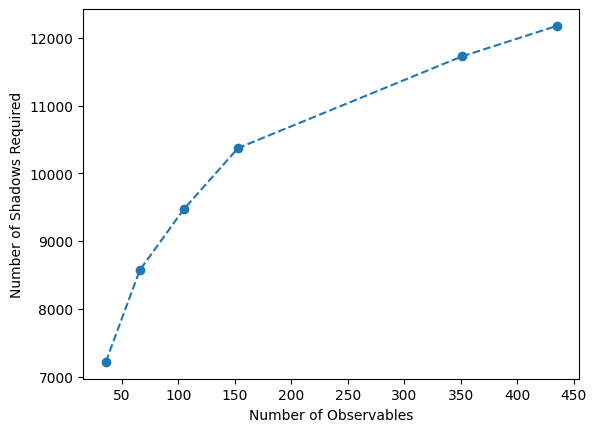

In [20]:
plt.xlabel('Number of Observables')
plt.ylabel('Number of Shadows Required')
plt.plot(observable_count,shadow_count, '--o')
plt.show()